# The Musk Effect on Dogecoin: A Data-Driven Analysis

### Dependencies

In [925]:
import os
import re
from io import BytesIO
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import requests
from PIL import Image
from wordcloud import WordCloud
from bokeh.io import output_file, save, show
from bokeh.layouts import column
from bokeh.models import ColumnDataSource, DataTable, Div, TableColumn
from bokeh.plotting import show
from IPython.display import HTML, display
from mplfinance.original_flavor import candlestick_ohlc
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def format_title(title):
    tmp = title.lower()
    tmp = tmp.replace(' ', '-')
    tmp = tmp.replace("'", "")
    tmp = tmp.replace(':', '')
    return tmp

if not os.path.exists('out'):
    os.makedirs('out')

try:
    nltk.data.find('sentiment/vader_lexicon.zip')
except LookupError:
    nltk.download('vader_lexicon')

## Visualizations

### Interactive Tables Using Bokeh

In [926]:
def plot_interactive_table(df, title):
    page_title = Div(text=f'<h1>{title}</h1>')
    output_file(f'out/{format_title(title)}.html', title=title)

    info_title = Div(text='<h2>Information</h2>')
    info_dict = {
        'Column': df.columns,
        'Count': df.count(),
        'Null Count': df.isnull().sum(),
        'Unique Count': df.nunique(),
        'Data Type': df.dtypes.astype(str)
    }
    info_df = pd.DataFrame(info_dict)
    info_source = ColumnDataSource(info_df)
    info_columns = [
        TableColumn(field='Column', title='Column'),
        TableColumn(field='Count', title='Count'),
        TableColumn(field='Null Count', title='Null Count'),
        TableColumn(field='Unique Count', title='Unique Count'),
        TableColumn(field='Data Type', title='Data Type')
    ]
    info_data_table = DataTable(source=info_source, columns=info_columns, height=25*(len(df.columns)+1))

    stats_title = Div(text='<h2>Descriptive Statistics</h2>')
    stats = df.describe().reset_index()
    stats_source = ColumnDataSource(stats)
    stats_columns = [TableColumn(field=col, title=col) for col in stats.columns]
    stats_data_table = DataTable(source=stats_source, columns=stats_columns, height=25*(len(stats)+1))

    layout = column(page_title, info_title, info_data_table, stats_title, stats_data_table)
    show(layout)
    save(layout)

### Tweet Frames Using IPython

In [927]:
def display_tweet_frame(html, title):
    with open(f'out/{format_title(title)}.html', 'w', encoding='utf-8') as file:
        file.write(html)
        file.close()
    display(HTML(html))

### Trading Charts Using Matplotlib

In [928]:
def plot_trading_chart(df, title, dates, time_period=None, bull=None, bear=None):
    start_date = dates[0]
    end_date = dates[1]
    filtered_df = df.set_index('Timestamp').loc[start_date:end_date]
    filtered_df = (
        filtered_df.resample('D')
        .agg({
            'Open': 'first',
            'High': 'max',
            'Low': 'min',
            'Close': 'last',
            'Volume': 'sum',
        })
        .dropna()
    )

    filtered_df['Date'] = filtered_df.index.map(mdates.date2num)
    ohlc_data = filtered_df[['Date', 'Open', 'High', 'Low', 'Close']].reset_index(drop=True).values
    highest_value = filtered_df['High'].max()
    lowest_value = filtered_df['Low'].min()

    fig = plt.figure(figsize=(10, 6))
    gs = fig.add_gridspec(2, 1, height_ratios=[3, 1])
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])

    colorup = '#4CAF50'
    colordown = '#F44336'
    
    candlestick_ohlc(ax1, ohlc_data, width=0.5, colorup=colorup, colordown=colordown)
    ax1.grid(True, linestyle='-', alpha=0.1, color='black', linewidth=0.5)
    ax1.axhline(highest_value, color=colorup, alpha=0.5, linestyle='--', linewidth=2, label=f'Highest: {highest_value}')
    ax1.axhline(lowest_value, color=colordown, alpha=0.5, linestyle='--', linewidth=2, label=f'Lowest: {lowest_value}')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.xaxis_date()
    ax1.xaxis.set_major_locator(mdates.DayLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
    ax1.set_title(title)
    ax1.set_ylabel('Price (USD)')
    ax1.set_xlabel(time_period)
    ax1.legend()

    if bull:
        for start_date, end_date in bull:
            i = mdates.date2num(pd.to_datetime(start_date))
            j = mdates.date2num(pd.to_datetime(end_date))
            ax1.axvspan(i, j, color=colorup, alpha=0.1)
            
    if bear:
        for start_date, end_date in bear:
            i = mdates.date2num(pd.to_datetime(start_date))
            j = mdates.date2num(pd.to_datetime(end_date))
            ax1.axvspan(i, j, color=colordown, alpha=0.1)

    bullish_dates = []
    bullish_volumes = []
    bearish_dates = []
    bearish_volumes = []
    for i, j in filtered_df.iterrows():
        if j['Close'] > j['Open']:
            color = colorup
            bullish_dates.append(j.name)
            bullish_volumes.append(j['Volume'])
        else:
            color = colordown
            bearish_dates.append(j.name)
            bearish_volumes.append(j['Volume'])
        ax2.bar(i, j['Volume'], color=color)

    ax2.plot(
        bullish_dates,
        bullish_volumes,
        color=colorup,
        alpha=0.5,
        linewidth=2,
        linestyle='--',
        label='Bullish Trend'
    )
    ax2.plot(
        bearish_dates,
        bearish_volumes,
        color=colordown,
        alpha=0.5,
        linewidth=2,
        linestyle='--',
        label='Bearish Trend'
    )

    ax2.fill_between(bullish_dates, bullish_volumes, color=colorup, alpha=0.1)
    ax2.fill_between(bearish_dates, bearish_volumes, color=colordown, alpha=0.1)
    ax2.grid(True, axis='y', linestyle='-', alpha=0.1, color='black', linewidth=0.5)
    ax2.set_ylabel('Volume')
    ax2.set_xlabel(time_period)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.xaxis.set_major_locator(mdates.DayLocator())
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
    ax2.legend()

    plt.tight_layout()
    plt.savefig(f'out/{format_title(title)}.png')

### WordCloud Charts Using Matplotlib

In [929]:
def plot_wordcloud_chart(df, title, crypto_name=''):
    filtered_df = df[df['Tweet'].str.contains(crypto_name, case=False, na=False)]
    tweets = ' '.join(filtered_df['Tweet'].dropna())
    tweets = tweets.replace('BTC', 'Bitcoin').replace('DOGE', 'Doge')

    keywords_colors = {
        'Bitcoin': '#F7931A',
        'Doge': '#BA9F33',
        'Tesla': '#E82127',
        'SpaceX': '#004B87',
    }
    keyword_counts = {keyword: tweets.lower().count(keyword.lower()) for keyword in keywords_colors}
    word_frequencies = {}
    for word, count in keyword_counts.items():
        word_frequencies[word] = count * 100
    for word in re.findall(r'\w+', tweets):
        word_frequencies[word] = word_frequencies.get(word, 0) + 1

    url = 'https://raw.githubusercontent.com/robertovicario/uninsubria-DataVisualization-Project-Work/main/assets/img/twitter.png'
    response = requests.get(url)
    bg_img = Image.open(BytesIO(response.content)).convert('L')
    mask = np.array(bg_img)

    def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
        if word in keywords_colors:
            return keywords_colors[word]
        else:
            return '#C0C0C0'

    wordcloud = WordCloud(background_color='white',
                          mask=mask,
                          max_words=1000,
                          color_func=color_func,
                          contour_color='#1DA1F2',
                          contour_width=2,
                          relative_scaling=0.5).generate_from_frequencies(word_frequencies)

    plt.figure(figsize=(6, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.savefig(f'out/{format_title(title)}.png')

## Exploratory Data Anaysis (EDA)

In [930]:
doge_prices = pd.read_csv('data/doge_prices.csv')
musk_tweets = pd.read_csv('data/musk_tweets.csv')

### DOGE Prices Dataset Overview

In [931]:
plot_interactive_table(doge_prices, 'Dogecoin Prices Dataset Overview')

### Musk Tweets Dataset Overview

In [932]:
plot_interactive_table(musk_tweets, 'Elon Musk Tweets Dataset Overview')

## Musk Effect: Main Episodes

In [933]:
doge_df = pd.read_csv('data/doge_prices.csv', parse_dates=['Timestamp'])

### The People's Crypto

In [934]:
html = '<blockquote class="twitter-tweet"><p lang="en" dir="ltr">Dogecoin is the people’s crypto</p>&mdash; Elon Musk (@elonmusk) <a href="https://twitter.com/elonmusk/status/1357241340313141249?ref_src=twsrc%5Etfw">February 4, 2021</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>'
title = "The People's Crypto"
display_tweet_frame(html=html, title=title)

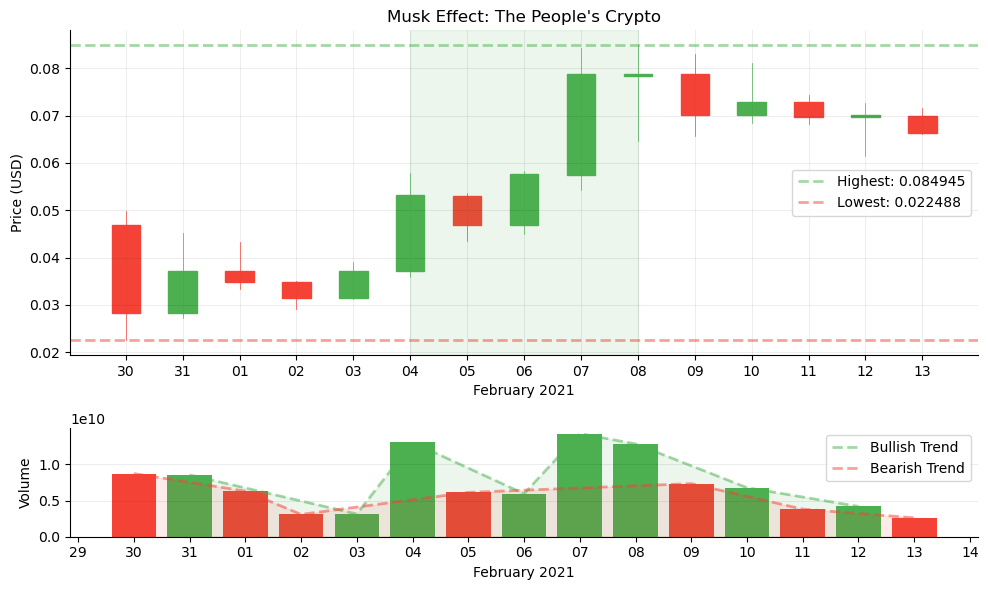

In [935]:
title = "Musk Effect: The People's Crypto"
dates = ['2021-01-30', '2021-02-13']
time_period = 'February 2021'
bull = [('2021-02-04', '2021-02-08')]
plot_trading_chart(df=doge_df,
                   title=title,
                   dates=dates,
                   time_period=time_period,
                   bull=bull)

### The Dogefather

In [936]:
html = '<blockquote class="twitter-tweet" data-theme="light"><p lang="en" dir="ltr">The Dogefather<br>SNL May 8</p>&mdash; Elon Musk (@elonmusk) <a href="https://twitter.com/elonmusk/status/1387290679794089986?ref_src=twsrc%5Etfw">April 28, 2021</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>'
title = "The Dogefather"
display_tweet_frame(html=html, title=title)

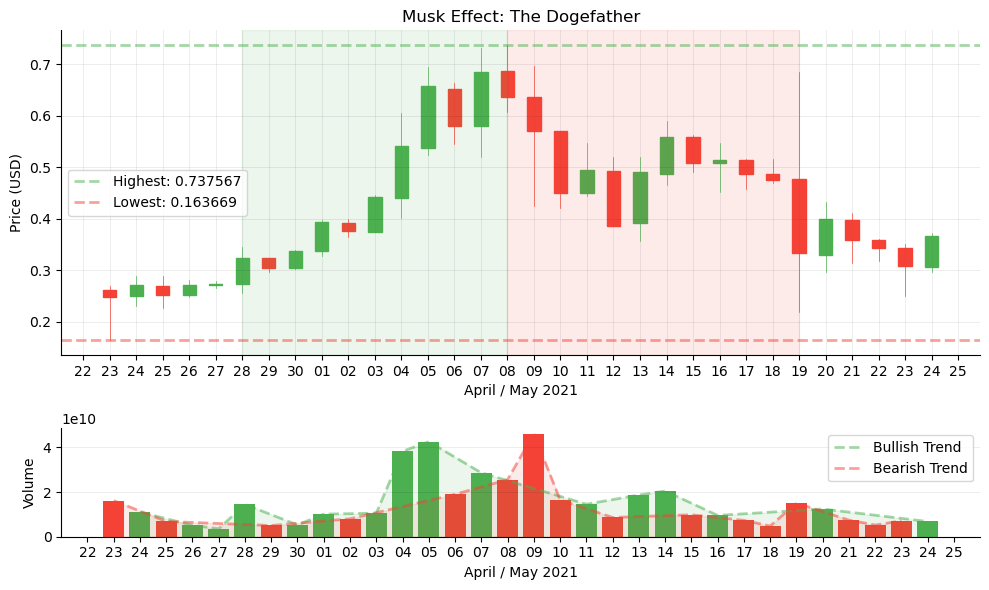

In [937]:
title = "Musk Effect: The Dogefather"
dates = ['2021-04-23', '2021-05-24']
time_period = 'April / May 2021'
bull = [('2021-04-28', '2021-05-08')]
bear = [('2021-05-08', '2021-05-19')]
plot_trading_chart(df=doge_df,
                   title=title,
                   dates=dates,
                   time_period=time_period,
                   bull=bull,
                   bear=bear)

### Doge Devs Collabs

In [938]:
html = '<blockquote class="twitter-tweet"><p lang="en" dir="ltr">Working with Doge devs to improve system transaction efficiency. Potentially promising.</p>&mdash; Elon Musk (@elonmusk) <a href="https://twitter.com/elonmusk/status/1392974251011895300?ref_src=twsrc%5Etfw">May 13, 2021</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>'
title = "Doge Devs Collabs"
display_tweet_frame(html=html, title=title)

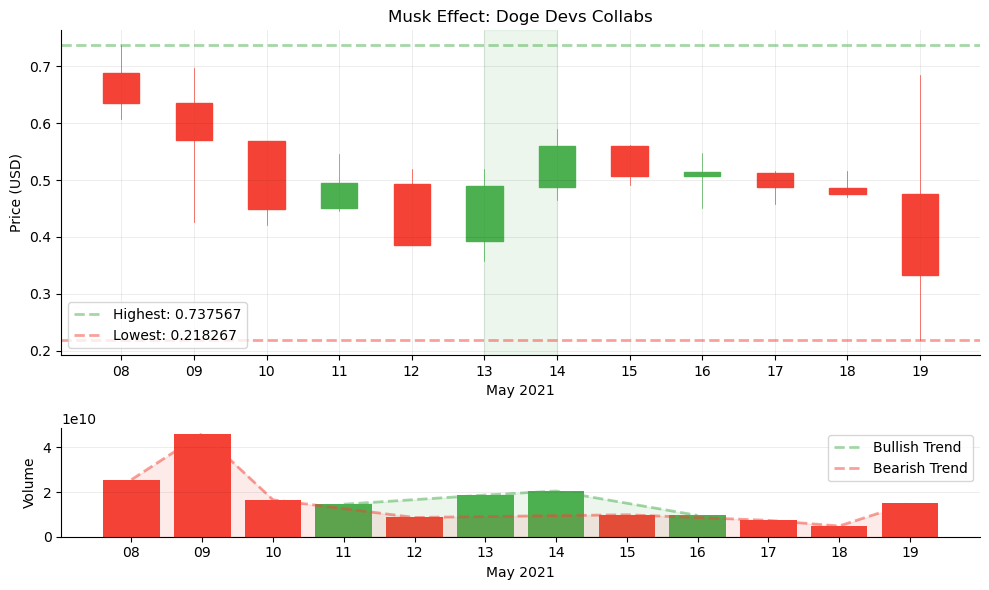

In [939]:
title = "Musk Effect: Doge Devs Collabs"
dates = ['2021-05-08', '2021-05-19']
time_period = 'May 2021'
bull = [('2021-05-13', '2021-05-14')]
plot_trading_chart(df=doge_df,
                   title=title,
                   dates=dates,
                   time_period=time_period,
                   bull=bull)

### Let That Sink In

In [940]:
html = '<blockquote class="twitter-tweet"><p lang="en" dir="ltr">Entering Twitter HQ – let that sink in! <a href="https://t.co/D68z4K2wq7">pic.twitter.com/D68z4K2wq7</a></p>&mdash; Elon Musk (@elonmusk) <a href="https://twitter.com/elonmusk/status/1585341984679469056?ref_src=twsrc%5Etfw">October 26, 2022</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>'
title = "Let That Sink In"
display_tweet_frame(html=html, title=title)

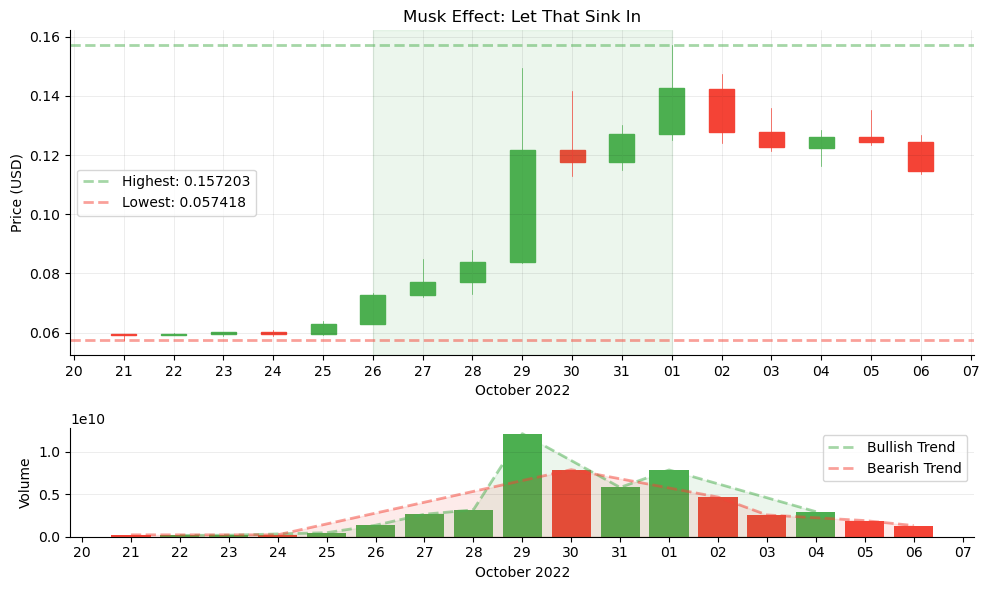

In [941]:
title = "Musk Effect: Let That Sink In"
dates = ['2022-10-21', '2022-11-06']
time_period = 'October 2022'
bull = [('2022-10-26', '2022-11-01')]
plot_trading_chart(df=doge_df,
                   title=title,
                   dates=dates,
                   time_period=time_period,
                   bull=bull)

### Twitter's New Icon

In [942]:
html = '<blockquote class="twitter-tweet"><p lang="zxx" dir="ltr"><a href="https://t.co/wmN5WxUhfQ">pic.twitter.com/wmN5WxUhfQ</a></p>&mdash; Elon Musk (@elonmusk) <a href="https://twitter.com/elonmusk/status/1642962756906418176?ref_src=twsrc%5Etfw">April 3, 2023</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>'
title = "Twitter's New Icon"
display_tweet_frame(html=html, title=title)

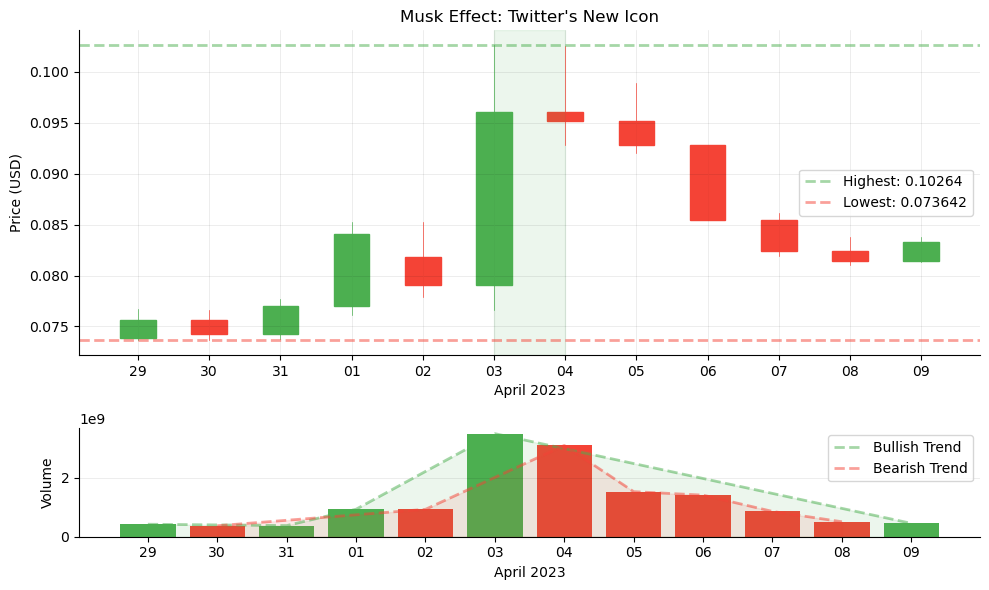

In [943]:
title = "Musk Effect: Twitter's New Icon"
dates = ['2023-03-29', '2023-04-09']
time_period = 'April 2023'
bull = [('2023-04-03', '2023-04-04')]
plot_trading_chart(df=doge_df,
                   title=title,
                   dates=dates,
                   time_period=time_period,
                   bull=bull)

## Musk Tweets: An Overview

In [944]:
musk_tweets = pd.read_csv('data/musk_tweets.csv', parse_dates=['Timestamp'])

### Emerging Topics in Musk Tweets

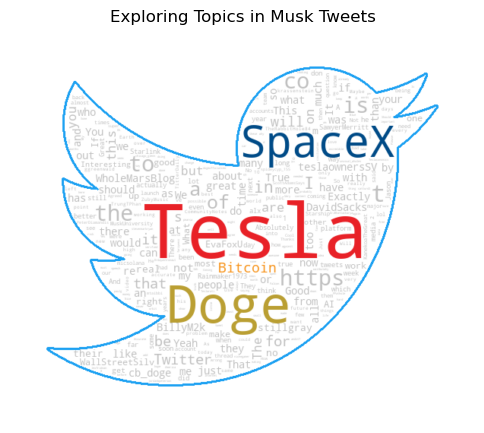

In [945]:
plot_wordcloud_chart(musk_tweets, 'Exploring Topics in Musk Tweets')

### Exploring Topics in Musk Tweets by Dogecoin

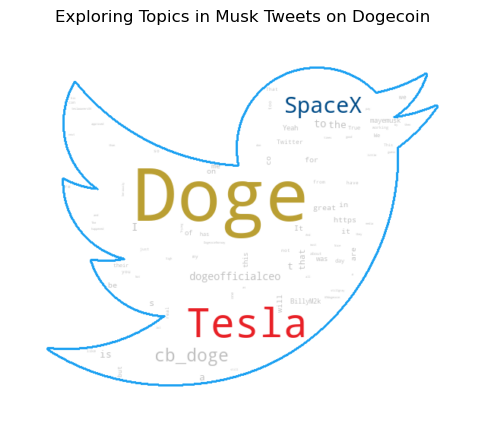

In [946]:
plot_wordcloud_chart(musk_tweets, 'Exploring Topics in Musk Tweets on Dogecoin', 'Doge')

### Sentiment Analysis Using NLTK

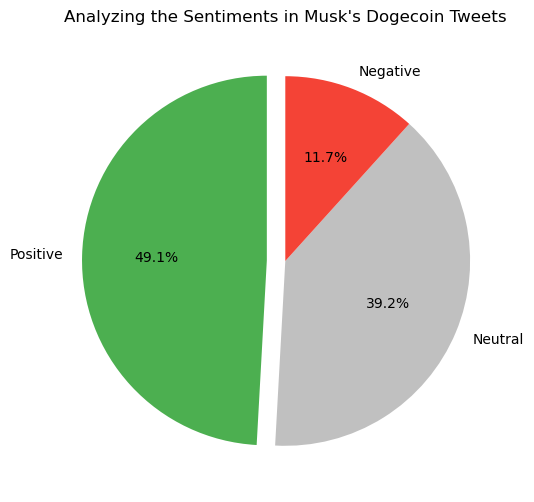

In [947]:
def get_sentiment(tweet):
    sentiment = SentimentIntensityAnalyzer().polarity_scores(tweet)
    return sentiment['compound']

def sentiment_category(score):
    if score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'

doge_tweets = musk_tweets[musk_tweets['Tweet'].str.contains('doge', case=False, na=False)].copy()
doge_tweets.loc[:, 'Sentiment'] = doge_tweets['Tweet'].apply(get_sentiment)
doge_tweets.loc[:, 'SentimentLabel'] = doge_tweets['Sentiment'].apply(sentiment_category)
sentiment_counts = doge_tweets['SentimentLabel'].value_counts()
explode = [0.1 if label == sentiment_counts.idxmax() else 0 for label in sentiment_counts.index]

plt.figure(figsize=(6, 6))
plt.pie(sentiment_counts,
        labels=sentiment_counts.index,
        explode=explode,
        colors=['#4CAF50', '#C0C0C0', '#F44336'],
        autopct='%1.1f%%',
        startangle=90)
title = "Analyzing the Sentiments in Musk's Dogecoin Tweets"
plt.title(title)
plt.savefig(f'out/{format_title(title)}.png')
plt.show()